In [14]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

Notes:

* id set as index. these are in reverse chron order
* missing indices are missing videos from tiktok

In [15]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

def preprocess(data):
    data['hashtags'] = data['hashtags'].str.lower()
    # create some date helper cols
    data['month'] = data['viewtime'].dt.month
    data['year'] = data['viewtime'].dt.year
    data['dateorder'] = np.where(data['month'].astype('str').str.len() == 1, data['year'].astype('str') + str(0) + data['month'].astype('str'), data['year'].astype('str') + data['month'].astype('str'))

    return data

In [16]:
path1 = 'tiktok_video_data_hashtags.csv'
tiktok_videos = pd.read_csv(path1).set_index('id').drop(index=0) #dropping this missing hashtag video)
# convert to datetime
tiktok_videos['viewtime'] = pd.to_datetime(tiktok_videos['viewtime'])
tiktok_videos =  preprocess(tiktok_videos)
tiktok_videos.columns

Index(['viewtime', 'author', 'sound', 'url', 'hashtags', 'month', 'year',
       'dateorder'],
      dtype='object')

In [17]:
videos_notags = tiktok_videos[tiktok_videos['hashtags'].isnull()].shape[0]
pct_notags = videos_notags / tiktok_videos.shape[0]
pct_notags

0.22394619627739595

In [18]:
path2 = 'tiktok_video_hashtags_exploded.csv'
hashtags_exploded = pd.read_csv(path2)
hashtags_exploded = hashtags_exploded.set_index('id')
hashtags_exploded = pd.merge(hashtags_exploded, tiktok_videos[['viewtime']], how='left', left_index=True, right_index=True)
hashtags_exploded = preprocess(hashtags_exploded)

dupedict = {'meme': 'memes', 'car': 'cars', 'carsoftiktok': 'cars', 'funnyvideo':'funnyvideos', \
            'genshin': 'genshinimpact', 'movie': 'movies', 'movieclip': 'movies', 'movieclips': 'movies',\
            'joke':'jokes', 'lawyertiktok':'lawyersoftiktok', 'mickey': 'mickeymouse', 'animetiktok': 'anime', \
            'animation':'anime', 'animeedit': 'anime'}
hashtags_exploded.loc[:,'hashtags'].replace(to_replace=dupedict, inplace=True)

hashtags_exploded.shape, hashtags_exploded.columns

((299800, 5),
 Index(['hashtags', 'viewtime', 'month', 'year', 'dateorder'], dtype='object'))

## Create Hashtag Metadata DataFrame

In [19]:
# generates hashtag metadata df
hashtags_metadata = hashtags_exploded.copy()

# combine dupe tags

print(hashtags_metadata.columns)

# gets index of video where this hashtag first occurs
hashtags_metadata = hashtags_metadata.reset_index()\
    .set_index('hashtags')\
    .sort_values(by='id', ascending=False)\
    .groupby('hashtags').first()\
    .rename(columns={'id': 'first_idx', 'viewtime': 'timeviewed'})

print(hashtags_metadata.columns)

# uses first_idx to get viewtime of the video from tt_video
hashtags_metadata = pd.merge(hashtags_metadata, tiktok_videos[['viewtime']], left_on='first_idx', right_index=True, how="left").rename(columns={'viewtime': 'firstseen', 'timeviewed': 'viewtime'})
print(hashtags_metadata.columns)

# creates count of this ht
ht_counts = hashtags_exploded['hashtags'].value_counts().rename('count')

hashtags_metadata = pd.merge(hashtags_metadata, ht_counts, how="left", left_index=True, right_index=True).sort_values(by='count', ascending=False)
print(hashtags_metadata.columns)

Index(['hashtags', 'viewtime', 'month', 'year', 'dateorder'], dtype='object')
Index(['first_idx', 'timeviewed', 'month', 'year', 'dateorder'], dtype='object')
Index(['first_idx', 'viewtime', 'month', 'year', 'dateorder', 'firstseen'], dtype='object')
Index(['first_idx', 'viewtime', 'month', 'year', 'dateorder', 'firstseen',
       'count'],
      dtype='object')


In [20]:
# generate weighted frequency: total counts / relative number of videos shown after the first occurrence of this hashtags
hashtags_metadata.shape

(40774, 7)

In [21]:
hashtags_metadata.to_csv('out_hashtags_metadata.csv')

In [22]:
# # test code for accuracy
# hashtags_metadata[hashtags_metadata['count'] == 2]
# tiktok_videos[(tiktok_videos['hashtags'].notnull()) & (tiktok_videos['hashtags'].str.contains('ifitsgonewegotit'))
#              ]

## Create Filter Ads Function

In [23]:
# define filter ads fn based on 3 rules
# per TT documentation - Usernames can only contain letters, numbers, underscores, and periods. However, periods can't be put at the end of the username.

def filter_ads(data):
    # RULE 1: Author; create column for ad flag and flags authors with regex pattern title as true
    regex = "[^a-z0-9_.]|\.$"
    data['ad_flag'] = np.where(tiktok_videos['author'].str.contains(pat=regex), True, False)
    
    # RULE 2: Sound
    sound_condition = (data['sound'].str.contains('Promoted')) & (data['ad_flag'] == False)
    data.loc[data[sound_condition].index,'ad_flag'] = True
    
    # RULE 3: Hashtag ad/promoted 
    adpat ='ad|advert\w+|promo\w+|sponsor\w+|sponcon' # add new ad related hashtags here as regex
    adtags = hashtags_exploded[hashtags_exploded['hashtags'].str.fullmatch(adpat, flags=re.IGNORECASE, na=False)]
    adidx = adtags.index.unique().tolist()
    tiktok_videos.loc[adidx,'ad_flag'] = True 
    return data

In [24]:
# scratchpad 
# tiktok_videos.index.isin(hashtags_exploded.index.unique())
# # verify promoted sounds and authors match
# addtl_vids = tiktok_videos[(tiktok_videos['sound'].str.contains('Promoted')) & (tiktok_videos['ad_flag'] == False)]
# (addtl_vids['author'] != addtl_vids['sound'].str.split(' - ', expand=True)[1]).sum()

# tiktok_videos[(tiktok_videos['hashtags'].str.contains(r'[A-Z]')) & (tiktok_videos['hashtags'].notnull())]

In [25]:
# filter ads

In [26]:
tiktok_videos = filter_ads(tiktok_videos)
ad_count = tiktok_videos['ad_flag'].sum()
ad_pct = (ad_count/tiktok_videos.shape[0])

# create advertiser summary
advertiser_summary = tiktok_videos[tiktok_videos['ad_flag'] == True].groupby(['author']).count().sort_values(by='viewtime', ascending=False).iloc[:,:1].rename(columns={'viewtime': '#ads'})

## PLOT: Advertisers

In [30]:
topadvertiserslist = advertiser_summary.head(20).index.tolist()

# FILTER VIDS BY TOP ADVERTISERS
topadvertisers_ads = tiktok_videos[tiktok_videos['author'].isin(topadvertiserslist)]

# export for tableau
topadvertisers_ads.to_csv('out_topadvertisers_ads.csv')

In [34]:
advertiser_summary.head(50)

,#ads
author,
SamsungUS,186
Amazon,125
Amazon Shopping,124
Apple,80
DoorDash,72
"Warhammer 40,000: Lost Crusade",62
Truebill Budget & Bill Tracker,61
Hirect: Chat Based Job Search,50
Cerebral,49


In [36]:
topadvertiserslist = advertiser_summary.head(50).index.tolist()

# FILTER VIDS BY TOP ADVERTISERS
topadvertisers_ads = tiktok_videos[(tiktok_videos['author'].isin(topadvertiserslist)) & (tiktok_videos['ad_flag']==True)]

# export for tableau
topadvertisers_ads.to_csv('export_top50advertisers_ads.csv')

---

## Advertisements Rank Analysis

### Question: Who are the top advertisers?

In [235]:
tiktok_videos.head()

,viewtime,author,sound,url,hashtags,month,year,dateorder,ad_flag,date
id,,,,,,,,,,
1,2022-02-09 23:38:00,movie102586,original sound - movie102586,https://www.tiktokv.com/share/video/7054979280417246511/,"movie,fyp,movie2022",2,2022,202202,False,2022-02-09
2,2022-02-09 23:37:00,movie102586,original sound - movie102586,https://www.tiktokv.com/share/video/7054978950115806511/,"movie,fyp,movie2022",2,2022,202202,False,2022-02-09
3,2022-02-09 23:36:00,movie102586,original sound - movie102586,https://www.tiktokv.com/share/video/7054973716429770031/,"movie,fyp,movie2022",2,2022,202202,False,2022-02-09
5,2022-02-09 23:36:00,movie102586,original sound - movie102586,https://www.tiktokv.com/share/video/7054965869947931951/,"movie,fyp,movie2022",2,2022,202202,False,2022-02-09
6,2022-02-09 23:35:00,movie102586,original sound - movie102586,https://www.tiktokv.com/share/video/7054973213385936174/,"movie,fyp,movie2022",2,2022,202202,False,2022-02-09


In [236]:
all_ad_videos = tiktok_videos[tiktok_videos['ad_flag'] == True]
all_ad_videos['date'] = pd.to_datetime(all_ad_videos['date'])
all_ad_videos['month'] = all_ad_videos['date'].dt.month
all_ad_videos.head()

<ipython-input-236-a16deb787da1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_ad_videos['date'] = pd.to_datetime(all_ad_videos['date'])
<ipython-input-236-a16deb787da1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_ad_videos['month'] = all_ad_videos['date'].dt.month


,viewtime,author,sound,url,hashtags,month,year,dateorder,ad_flag,date
id,,,,,,,,,,
11,2022-02-09 23:33:00,Done.,Promoted Music - Done.,https://www.tiktokv.com/share/video/7062180996027927810/,NaN,2,2022,202202,True,2022-02-09
19,2022-02-09 23:31:00,LunexPods,Promoted Music - LunexPods,https://www.tiktokv.com/share/video/7062572463569259777/,NaN,2,2022,202202,True,2022-02-09
29,2022-02-09 23:30:00,Amazon Shopping,Promoted Music - Amazon Shopping,https://www.tiktokv.com/share/video/7042028562567662849/,NaN,2,2022,202202,True,2022-02-09
36,2022-02-09 23:27:00,Last Fortress,Promoted Music - Last Fortress,https://www.tiktokv.com/share/video/7056739591524519169/,NaN,2,2022,202202,True,2022-02-09
44,2022-02-09 18:52:00,Poképet,Promoted Music - Poképet,https://www.tiktokv.com/share/video/7062614684079361282/,NaN,2,2022,202202,True,2022-02-09


## Top Monthly Advertiser Ranks by Month

In [237]:
rank_limit = 5
top_monthly_advertisers = all_ad_videos.groupby(['month','year','author','dateorder']).count().sort_values(by=['dateorder','ad_flag'], ascending=[True,False])[['ad_flag']]
print(top_monthly_advertisers.shape)
top_monthly_advertisers = top_monthly_advertisers.reset_index().groupby('dateorder').head(rank_limit)
print(top_monthly_advertisers.shape)

rank_list = list(range(1,rank_limit+1))
rank = pd.Series(rank_list * len(top_monthly_advertisers['dateorder'].unique()), index=top_monthly_advertisers.index, name='rank')
top_monthly_advertisers = pd.concat([top_monthly_advertisers, rank], axis=1)

top_monthly_advertisers['datetime'] = pd.to_datetime(top_monthly_advertisers['month'].astype('str') +"-1-"+ top_monthly_advertisers['year'].astype('str'))

(1795, 1)
(40, 5)


In [238]:
top_monthly_advertisers

,month,year,author,dateorder,ad_flag,rank,datetime
0,7,2021,DoorDash,202107,7,1,2021-07-01
1,7,2021,Upward: Christian Dating,202107,7,2,2021-07-01
2,7,2021,State of Survival Walking Dead,202107,6,3,2021-07-01
3,7,2021,jeenie.weenie,202107,6,4,2021-07-01
4,7,2021,Amazon,202107,5,5,2021-07-01
40,8,2021,"Warhammer 40,000: Lost Crusade",202108,22,1,2021-08-01
41,8,2021,Amazon,202108,16,2,2021-08-01
42,8,2021,PLINK - Connecting Gamers,202108,9,3,2021-08-01
43,8,2021,Truebill Budget & Bill Tracker,202108,8,4,2021-08-01
44,8,2021,DoorDash,202108,7,5,2021-08-01


In [239]:
top_monthly_advertisers.to_csv('export_top5_monthly_ads.csv')

---

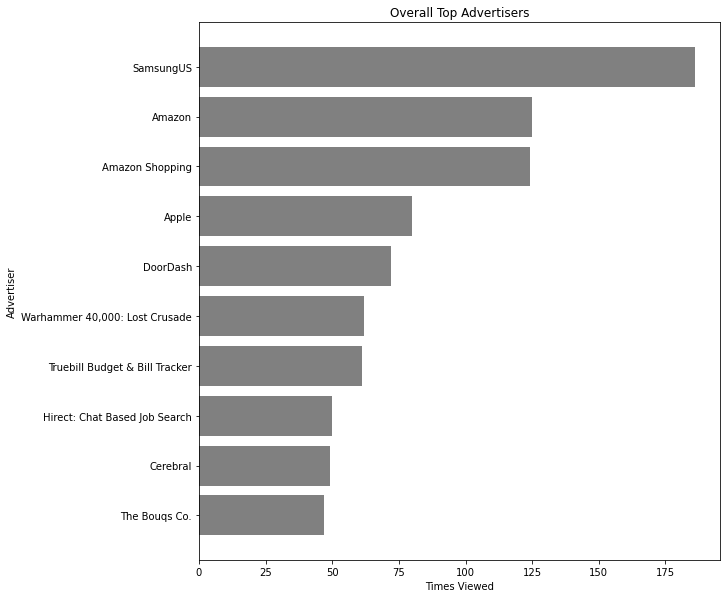

In [240]:
advertiser_plt = advertiser_summary.head(10).sort_values(by='#ads', ascending=True)
fig = plt.figure(figsize=(10,8))
plt.barh(advertiser_plt.index, advertiser_plt['#ads'], color='gray')
plt.tight_layout()
plt.title('Overall Top Advertisers')
plt.ylabel('Advertiser')
plt.xlabel('Times Viewed')
plt.show()

### Question: How often are advertisements shown per advertiser?

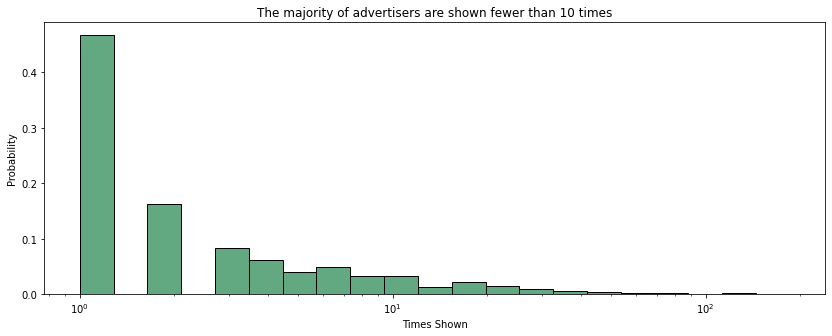

In [241]:
fig, ax = plt.subplots(figsize=(14,5))
sns.histplot(advertiser_summary, x='#ads', log_scale=True, stat="probability", color='seagreen')
ax.set_title('The majority of advertisers are shown fewer than 10 times')
ax.set_xlabel('Times Shown')
plt.show()

### Question: Does the number of unique advertisers decrease from when you first start using tiktok?
* theory: TT learning what ads are best tailored to you.
* plot unique advertisers per week, normalized by total vids?
* avg ads a week?


#### Construct Monthly Summary

In [242]:
tiktok_videos.columns

Index(['viewtime', 'author', 'sound', 'url', 'hashtags', 'month', 'year',
       'dateorder', 'ad_flag', 'date'],
      dtype='object')

In [243]:
vidspermonth = tiktok_videos.groupby('dateorder').count().iloc[:,1].rename('# videos')
adspermonth = tiktok_videos[ tiktok_videos['ad_flag'] == True].groupby('dateorder').count().iloc[:,1].rename('# ads')
pctadspermonth = round(adspermonth/vidspermonth, 2).rename('% ads')

authorspermonth = tiktok_videos.groupby(['dateorder','author']).count().reset_index().iloc[:,:2].groupby('dateorder').count().rename(columns={'author': '# authors'})
advertiserspermonth = tiktok_videos[tiktok_videos['ad_flag']==True].groupby(['dateorder','author']).count().reset_index().iloc[:,:2].groupby('dateorder').count().rename(columns={'author': '# advertisers'})

pctadvertisers = round(advertiserspermonth.iloc[:,0] / authorspermonth.iloc[:,0], 2).rename('% advertisers')

monthly_summary = pd.concat([vidspermonth, adspermonth, pctadspermonth, advertiserspermonth, authorspermonth, pctadvertisers], axis=1)

In [244]:
monthly_summary

,# videos,# ads,% ads,# advertisers,# authors,% advertisers
dateorder,,,,,,
202107,2797,86,0.03,40,878,0.05
202108,3585,160,0.04,64,1029,0.06
202109,3926,323,0.08,107,1749,0.06
202110,6987,607,0.09,191,3965,0.05
202111,11843,874,0.07,300,6334,0.05
202112,20197,1839,0.09,583,10015,0.06
202201,13848,1082,0.08,331,6595,0.05
202202,4619,495,0.11,179,2902,0.06


### Top advertising categories - hand label? maybe if time

In [245]:
top10pct = advertiser_summary['#ads'].quantile(0.90) # find value of 90th percentile advertisers
top_advertisers = advertiser_summary[advertiser_summary['#ads'] >= top10pct].copy() #hide head for full table of advertisers
top_advertisers['ad%'] = round(top_advertisers['#ads'] / ad_count, 3)

top_advertisers['adcategory'] = ""
top_advertisers.to_csv('out_top_advertisers.csv') # export for labeling

#### ( Hand label then come back )

### Advertisements Summary

In [246]:
videos_watched = tiktok_videos.shape[0]
print("Total number of videos viewed: %i" % videos_watched)
print("Total number of ads viewed: %i" % ad_count)
print("")

repeat_thresh = 2
advertiser_count = advertiser_summary.shape[0]
repeat_advertisers = advertiser_summary[advertiser_summary['#ads'] > repeat_thresh].shape[0]
print("Number of Unique Advertisers: %i " % advertiser_count)
print("Number of Repeat Advertisers (shown >)", str(repeat_thresh),"times) : %i " % repeat_advertisers)
print("")

print("Number of Unique Advertisers, first week on platform: %i " % 0)
print("Number of Unique Advertisers, last week on platform: %i " % 0)
print("")

print("List of top 10 advertisers, first week on platform: %i " % 0)
print("List of top 10 advertisers, last week on platform: %i " % 0)

print("\n--------------------")
print("Monthly summary of advertisements as part of video feed (Month 7 is the start)")
print("Avg Percent Total Videos Viewed that are ads: %.2f " % ad_pct)

display(monthly_summary)
monthly_summary.to_csv('out_monthly_summary_videos_ads.csv')

Total number of videos viewed: 67802
Total number of ads viewed: 5466

Number of Unique Advertisers: 1229 
Number of Repeat Advertisers (shown >) 2 times) : 455 

Number of Unique Advertisers, first week on platform: 0 
Number of Unique Advertisers, last week on platform: 0 

List of top 10 advertisers, first week on platform: 0 
List of top 10 advertisers, last week on platform: 0 

--------------------
Monthly summary of advertisements as part of video feed (Month 7 is the start)
Avg Percent Total Videos Viewed that are ads: 0.08 


,# videos,# ads,% ads,# advertisers,# authors,% advertisers
dateorder,,,,,,
202107,2797,86,0.03,40,878,0.05
202108,3585,160,0.04,64,1029,0.06
202109,3926,323,0.08,107,1749,0.06
202110,6987,607,0.09,191,3965,0.05
202111,11843,874,0.07,300,6334,0.05
202112,20197,1839,0.09,583,10015,0.06
202201,13848,1082,0.08,331,6595,0.05
202202,4619,495,0.11,179,2902,0.06


In [247]:

print("List of top 10 advertisers, first week on platform: %i " % 0)
print("List of top 10 advertisers, last week on platform: %i " % 0)


List of top 10 advertisers, first week on platform: 0 
List of top 10 advertisers, last week on platform: 0 


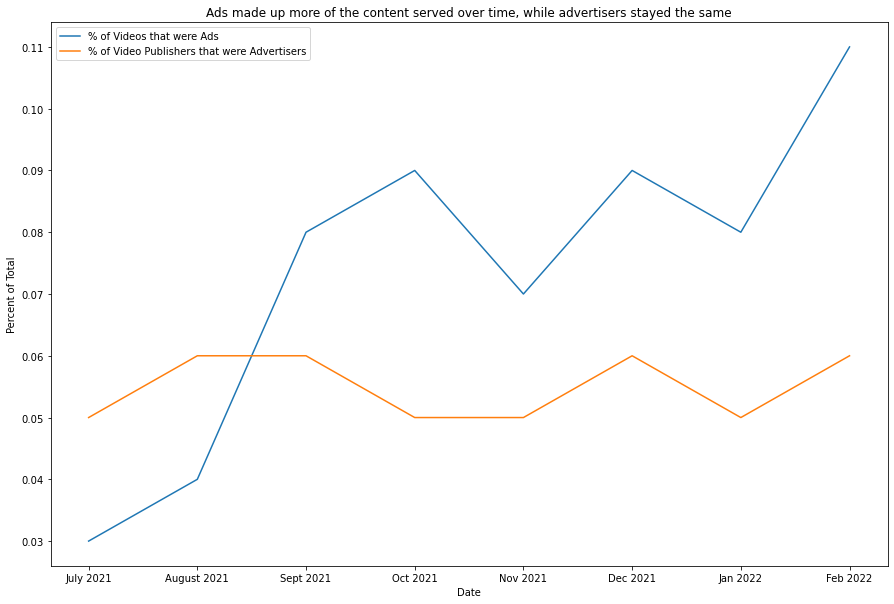

In [248]:
fig = plt.figure(figsize=(15,10))
labels = ['July 2021', 'August 2021','Sept 2021','Oct 2021','Nov 2021','Dec 2021', 'Jan 2022', 'Feb 2022']
xs = monthly_summary.index

sns.lineplot(data=monthly_summary, x='dateorder', y='% ads', label='% of Videos that were Ads')
sns.lineplot(data=monthly_summary, x='dateorder', y='% advertisers', label="% of Video Publishers that were Advertisers")

plt.legend()    
plt.title('Ads made up more of the content served over time, while advertisers stayed the same')
plt.xlabel('Date')
plt.ylabel('Percent of Total')


plt.xticks(xs, labels, rotation='0')
plt.show();

## Hashtag Analysis

### Which are the most popular hashtags (popular defined as occurring within top 1% of videos)?

In [249]:
top_ht = hashtags_metadata.copy()
top_ht['in%videos'] = round(top_ht['count'] / videos_watched,3)
# ht_thresh = top_ht['count'].quantile(0.99)
# top_ht = top_ht[top_ht['in%videos'] > 0.01]
top_ht.sort_values(by='count', ascending=False).head(110)

,first_idx,viewtime,month,year,dateorder,firstseen,count,in%videos
hashtags,,,,,,,,
fyp,78280,2021-07-03 07:47:00,7,2021,202107,2021-07-03 07:47:00,20243,0.299
foryou,78132,2021-07-04 02:01:00,7,2021,202107,2021-07-04 02:01:00,9912,0.146
fypシ,78101,2021-07-04 02:11:00,7,2021,202107,2021-07-04 02:11:00,6261,0.092
viral,78280,2021-07-03 07:47:00,7,2021,202107,2021-07-03 07:47:00,5622,0.083
foryoupage,78274,2021-07-03 07:48:00,7,2021,202107,2021-07-03 07:48:00,5347,0.079
...,...,...,...,...,...,...,...,...
computerscience,72406,2021-08-23 02:44:00,8,2021,202108,2021-08-23 02:44:00,214,0.003
education,75810,2021-07-21 16:40:00,7,2021,202107,2021-07-21 16:40:00,213,0.003
coding,60101,2021-10-27 23:34:00,10,2021,202110,2021-10-27 23:34:00,209,0.003


### Exclude fyp hashtags or TT-algorithm related hashtags

In [315]:
# define filter ads fn based on 3 rules
# per TT documentation - Usernames can only contain letters, numbers, underscores, and periods. However, periods can't be put at the end of the username.

def flag_tags(data):
    data = data.reset_index()
    data['exclude'] = False
    pat ='fy\w*|foryou\w*|fyp|fypシ゚viral|fypシ|foryoupage|duet|duetdowet|stitch|funny|viral|comedy|trending|trend|xyzbca|xyzcba|4u|tiktok|greenscreen\w*|followmemore|viralvideo' # add new ad related hashtags here as regex
    flags_filter = data['hashtags'].str.fullmatch(pat, flags=re.IGNORECASE, na=False)
    data.loc[flags_filter, 'exclude'] = True
    print(data['exclude'].sum())
    return data

In [316]:
filtered_top = flag_tags(hashtags_metadata)
filtered_top = filtered_top[filtered_top['exclude'] == False].sort_values(by='count', ascending=False).drop(columns='viewtime')
filtered_top = filtered_top.head(100).drop(columns='exclude')

159


In [317]:
filtered_top

,hashtags,first_idx,month,year,dateorder,firstseen,count
5,anime,77819,7,2021,202107,2021-07-07 07:58:00,4995
11,memes,77964,7,2021,202107,2021-07-06 07:45:00,2138
12,movies,78252,7,2021,202107,2021-07-03 07:57:00,2054
13,weeb,77819,7,2021,202107,2021-07-07 07:58:00,1254
16,vtuber,73519,8,2021,202108,2021-08-09 09:05:00,928
...,...,...,...,...,...,...,...
119,lmao,75848,7,2021,202107,2021-07-21 16:25:00,186
118,customersmostloved,38297,12,2021,202112,2021-12-11 08:10:00,186
120,2022,62160,10,2021,202110,2021-10-19 06:47:00,183
121,cartiktok,76974,7,2021,202107,2021-07-12 02:47:00,183


In [318]:
filteredht_list = filtered_top['hashtags'].to_list()[:30]
filteredht_list

['anime',
 'memes',
 'movies',
 'weeb',
 'vtuber',
 'jokes',
 'lawyersoftiktok',
 'waifu',
 'mickeymouse',
 'genshinimpact',
 'otaku',
 'cars',
 'gaming',
 'funnyvideos',
 'relatable',
 'carsoftiktok',
 'envtuber',
 'cosplay',
 'film',
 'lol',
 'twitch',
 'movieclips',
 'techtok',
 'answer',
 'tvclip',
 'asian',
 'minecraft',
 'learnontiktok',
 'twitchstreamer',
 'college']

In [319]:
top_ht.to_csv('out_top_ht.csv')
filtered_top.to_csv('out_filtered_topht.csv')
print('exported')

exported


### Top Hashtags, Filtered

In [320]:
# FILTER VIDS BY TOP hashtags
tophts_videos = hashtags_exploded[hashtags_exploded['hashtags'].isin(filteredht_list)]

tophts_videos

# export for tableau
tophts_videos.to_csv('out_tophts_videos.csv')

/Users/aliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/aliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


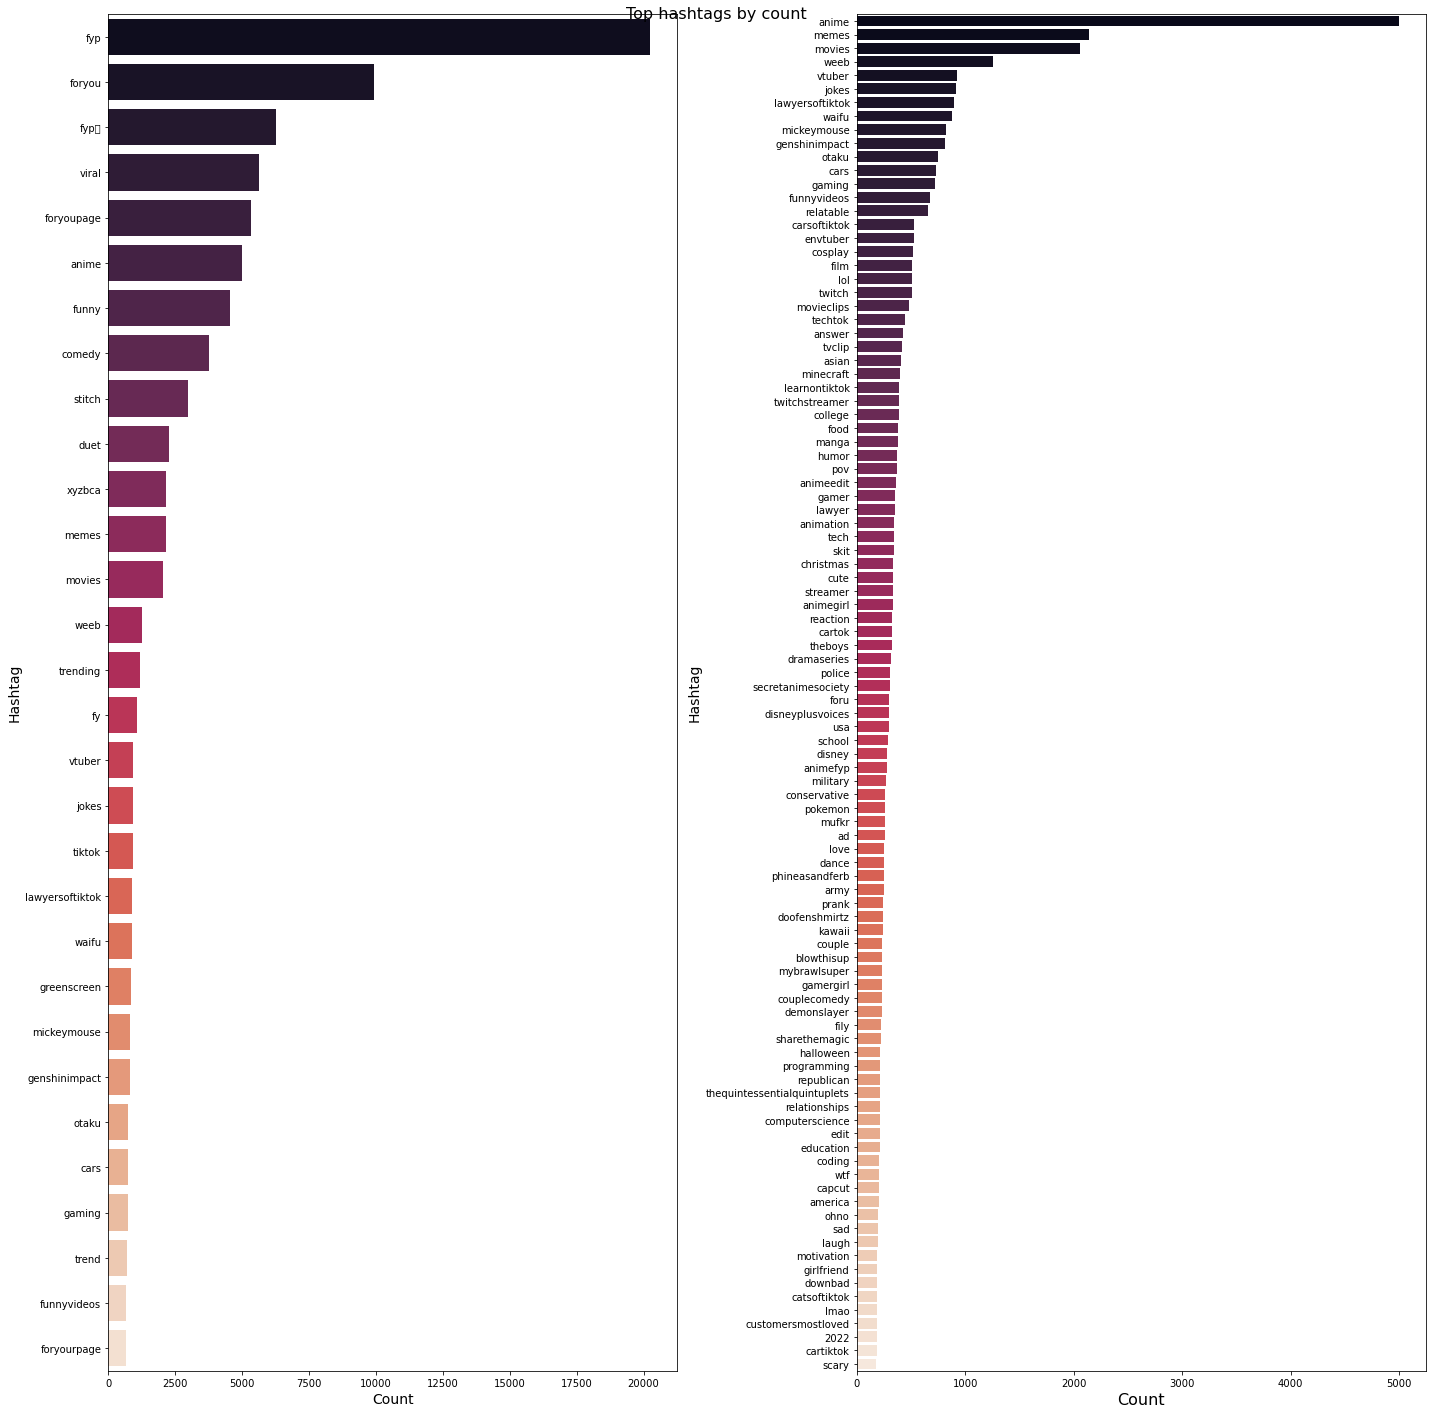

In [321]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
fig.suptitle('Top hashtags by count', fontsize=16)

top_ht = top_ht.head(30)

# fig = plt.figure(figsize=(20,20))
sns.barplot(data=top_ht, x='count', y=top_ht.index, orient='h', ax=ax[0], palette="rocket")
sns.barplot(data=filtered_top, x='count', y='hashtags', orient='h', ax=ax[1], palette="rocket")
ax[0].set_xlabel('Count', fontsize=14)
ax[0].set_ylabel('Hashtag', fontsize=14)
ax[1].set_xlabel('Count', fontsize=16)
ax[1].set_ylabel('Hashtag', fontsize=14)

# plt.show();

fig.tight_layout()
plt.show();


---

## Hashtags Rank Monthly

In [322]:
hashtags_exploded.shape

(299800, 5)

In [323]:
rank_limit_ht = 10

hashtags_relevant = flag_tags(hashtags_exploded)

hashtags_relevant = hashtags_relevant[hashtags_relevant['exclude']==False]
hashtags_rank = hashtags_relevant.groupby(['month','year','dateorder','hashtags']).count().sort_values(by=['dateorder','id'], ascending=[True,False]).reset_index().iloc[:,:5].rename(columns={'id':'count'})
hashtags_rank


71890


,month,year,dateorder,hashtags,count
0,7,2021,202107,mickeymouse,335
1,7,2021,202107,lawyersoftiktok,253
2,7,2021,202107,mufkr,92
3,7,2021,202107,phineasandferb,85
4,7,2021,202107,learnfromkhaby,84
...,...,...,...,...,...
66782,2,2022,202202,😳,1
66783,2,2022,202202,😷,1
66784,2,2022,202202,🤣,1
66785,2,2022,202202,🤨📸,1


In [324]:
hashtags_rank['datetime'] = pd.to_datetime(hashtags_rank['month'].astype('str') +"-1-"+ hashtags_rank['year'].astype('str'))
hashtags_rank.to_csv('export_hashtags_count_by_month.csv')

In [325]:

hashtags_rank = hashtags_rank.reset_index().groupby('dateorder').head(rank_limit_ht)[['month','year','dateorder','hashtags','count']].rename(columns={'id':'count'})
# hashtags_rank['date'] 
hashtags_rank['datetime'] = pd.to_datetime(hashtags_rank['month'].astype('str') +"-1-"+ hashtags_rank['year'].astype('str'))


rank_limit_ht = list(range(1,rank_limit_ht+1))


rank_ht = pd.Series(rank_limit_ht * len(hashtags_rank['dateorder'].unique()), index=hashtags_rank.index, name='rank')
hashtags_rank = pd.concat([hashtags_rank, rank_ht], axis=1)
hashtags_rank
hashtags_rank.to_csv('export_hashtags_rank.csv')


In [326]:
hashtags_rank

,month,year,dateorder,hashtags,count,datetime,rank
0,7,2021,202107,mickeymouse,335,2021-07-01,1
1,7,2021,202107,lawyersoftiktok,253,2021-07-01,2
2,7,2021,202107,mufkr,92,2021-07-01,3
3,7,2021,202107,phineasandferb,85,2021-07-01,4
4,7,2021,202107,learnfromkhaby,84,2021-07-01,5
...,...,...,...,...,...,...,...
60780,2,2022,202202,dramaseries,73,2022-02-01,6
60781,2,2022,202202,gaming,59,2022-02-01,7
60782,2,2022,202202,weeb,59,2022-02-01,8
60783,2,2022,202202,tvclip,54,2022-02-01,9


## Daily Counts Analysis

In [294]:
# calculate running total videos watched daily
tiktok_videos['date'] = tiktok_videos['viewtime'].dt.date 

daily_videos_watched = pd.DataFrame(tiktok_videos.groupby('date').count().iloc[:,1].rename('daily_videos_watched')).reset_index()
count_videos_by_date = tiktok_videos.groupby('date').count().sort_values(by='date', ascending=True).cumsum().iloc[:,0].rename('running_video_count')
daily_videos_watched


,date,daily_videos_watched
0,2021-07-03,118
1,2021-07-04,95
2,2021-07-05,32
3,2021-07-06,72
4,2021-07-07,160
...,...,...
201,2022-02-05,515
202,2022-02-06,604
203,2022-02-07,493
204,2022-02-08,588


In [295]:
count_videos_by_date

date
2021-07-03      118
2021-07-04      213
2021-07-05      245
2021-07-06      317
2021-07-07      477
              ...  
2022-02-05    65529
2022-02-06    66133
2022-02-07    66626
2022-02-08    67214
2022-02-09    67802
Name: running_video_count, Length: 206, dtype: int64

In [32]:
hashtags_metadata

,first_idx,viewtime,month,year,dateorder,firstseen,count
hashtags,,,,,,,
fyp,78280,2021-07-03 07:47:00,7,2021,202107,2021-07-03 07:47:00,20243
foryou,78132,2021-07-04 02:01:00,7,2021,202107,2021-07-04 02:01:00,9912
fypシ,78101,2021-07-04 02:11:00,7,2021,202107,2021-07-04 02:11:00,6261
viral,78280,2021-07-03 07:47:00,7,2021,202107,2021-07-03 07:47:00,5622
foryoupage,78274,2021-07-03 07:48:00,7,2021,202107,2021-07-03 07:48:00,5347
...,...,...,...,...,...,...,...
diversion,53439,2021-11-10 17:04:00,11,2021,202111,2021-11-10 17:04:00,1
divinetiming,32067,2021-12-17 09:16:00,12,2021,202112,2021-12-17 09:16:00,1
diving,32219,2021-12-17 06:23:00,12,2021,202112,2021-12-17 06:23:00,1


In [206]:
firstseendate = hashtags_metadata[['firstseen', 'count']].copy()
firstseendate['firstseen'] = hashtags_metadata['firstseen'].dt.date
firstseendate

,firstseen,count
hashtags,,
fyp,2021-07-03,20243
foryou,2021-07-04,9912
fypシ,2021-07-04,6261
viral,2021-07-03,5622
foryoupage,2021-07-03,5347
...,...,...
diversion,2021-11-10,1
divinetiming,2021-12-17,1
diving,2021-12-17,1


In [34]:
# # commenting out since this doesn't change the #s much
# hts_weighted = pd.merge(firstseendate, count_videos_by_date, left_on='firstseen', right_index=True, how='left')
# hts_weighted['weighted %'] = round(hts_weighted['count']/(videos_watched - hts_weighted['running_video_count']),3)
# hts_weighted_filtered = flag_tags(hts_weighted[hts_weighted['weighted %'] < np.inf].sort_values(by='weighted %', ascending=False))
# hts_weighted_filtered = hts_weighted_filtered[hts_weighted_filtered['exclude']==False]
# hts_weighted_filtered 

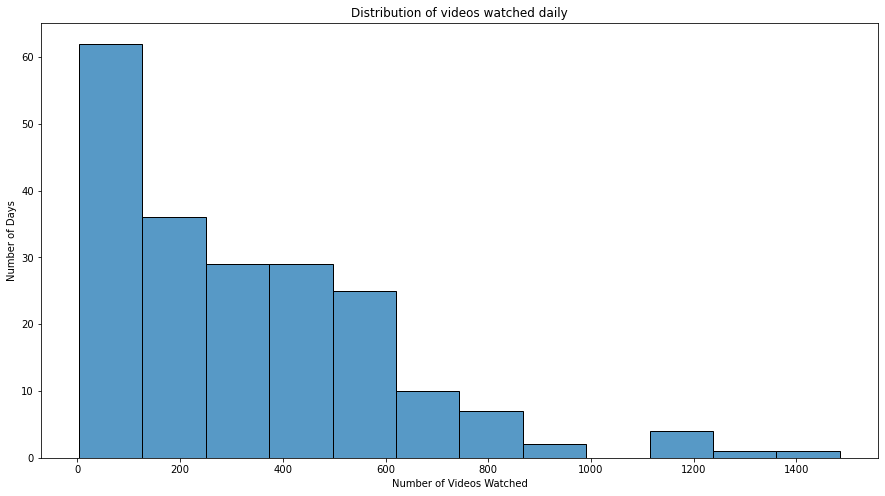

In [35]:
fig = plt.figure(figsize=(15,8))
sns.histplot(data=daily_videos_watched, label="a")
plt.title('Distribution of videos watched daily')
plt.xlabel('Number of Videos Watched')
plt.ylabel('Number of Days')
plt.legend().remove()
plt.show()

Text(0.5, 1.0, 'number of daily videos watched over time')

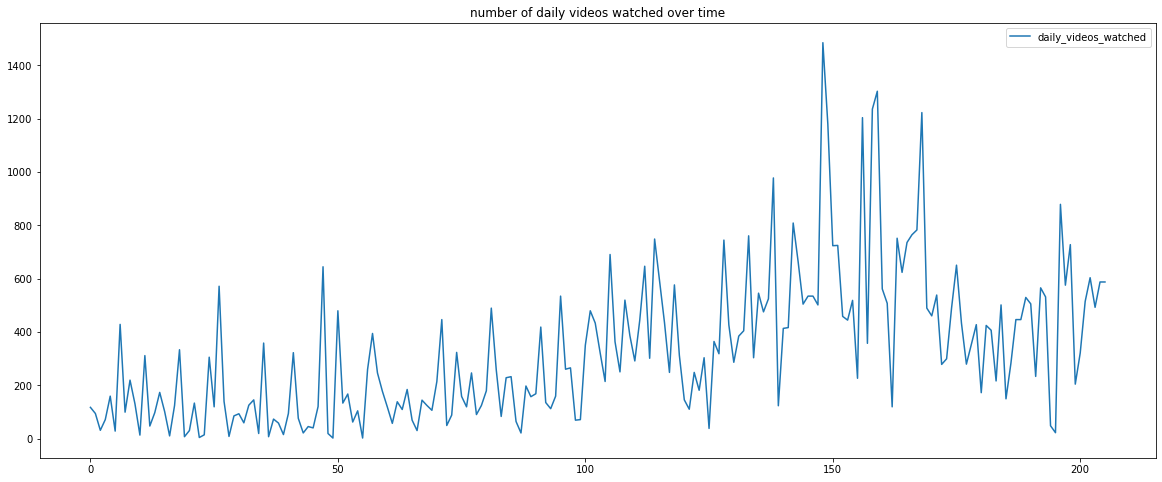

In [36]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(data=daily_videos_watched)
plt.title('number of daily videos watched over time')

<AxesSubplot:xlabel='date', ylabel='running_video_count'>

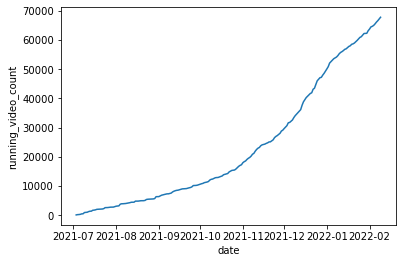

In [37]:
sns.lineplot(data=count_videos_by_date)

In [38]:
# top hashtags by rolling window


## PLAN

0. Treeplot
1. Show basic stuff - view patterns interests over time
2. Show how ads make up a bigger portion of your feed over time.
3. Show most popular ads, advertisers.
4. Ad explorer
5. Ad explorer + ht